In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/Tomato ')
os.listdir()

['train', 'val']

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [7]:
# Forming datasets

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.3)

train = datagen.flow_from_directory('./train', seed=123, subset='training')
val = datagen.flow_from_directory('./train', seed=123, subset='validation')

datagen2 = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test = datagen2.flow_from_directory('./val')

Found 7000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [8]:
# Training data visualization

classes = os.listdir('./train')

plt.figure(figsize=(25,10))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[0]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2,5,i[0]+1)
    plt.title('{0} / Shape = {1}'.format(i[1], image.shape))
    plt.imshow(image)
plt.show()

In [9]:
# Function to initialize model (ResNet152V2)

def get_model():
    
    base_model = ResNet152V2(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model

In [10]:
model = get_model()
model.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
# Model training
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy')
model.fit(train, batch_size=80, epochs=5, validation_data=val)

Epoch 1/5
219/219 [==============================] - 112s 463ms/step - loss: 0.0595 - accuracy: 0.9837 - val_loss: 0.0913 - val_accuracy: 0.9677
Epoch 2/5
219/219 [==============================] - 99s 453ms/step - loss: 0.0236 - accuracy: 0.9959 - val_loss: 0.0806 - val_accuracy: 0.9727
Epoch 3/5
219/219 [==============================] - 99s 453ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.0826 - val_accuracy: 0.9720
Epoch 4/5
219/219 [==============================] - 99s 453ms/step - loss: 0.0115 - accuracy: 0.9979 - val_loss: 0.0756 - val_accuracy: 0.9747
Epoch 5/5
219/219 [==============================] - 99s 453ms/step - loss: 0.0061 - accuracy: 0.9995 - val_loss: 0.0681 - val_accuracy: 0.9793


In [ ]:
model.evaluate(test)

32/32 [==============================] - 8s 252ms/step - loss: 0.1325 - accuracy: 0.9670


[0.13253800570964813, 0.9670000076293945]

We are getting around 96.7% accuracy.

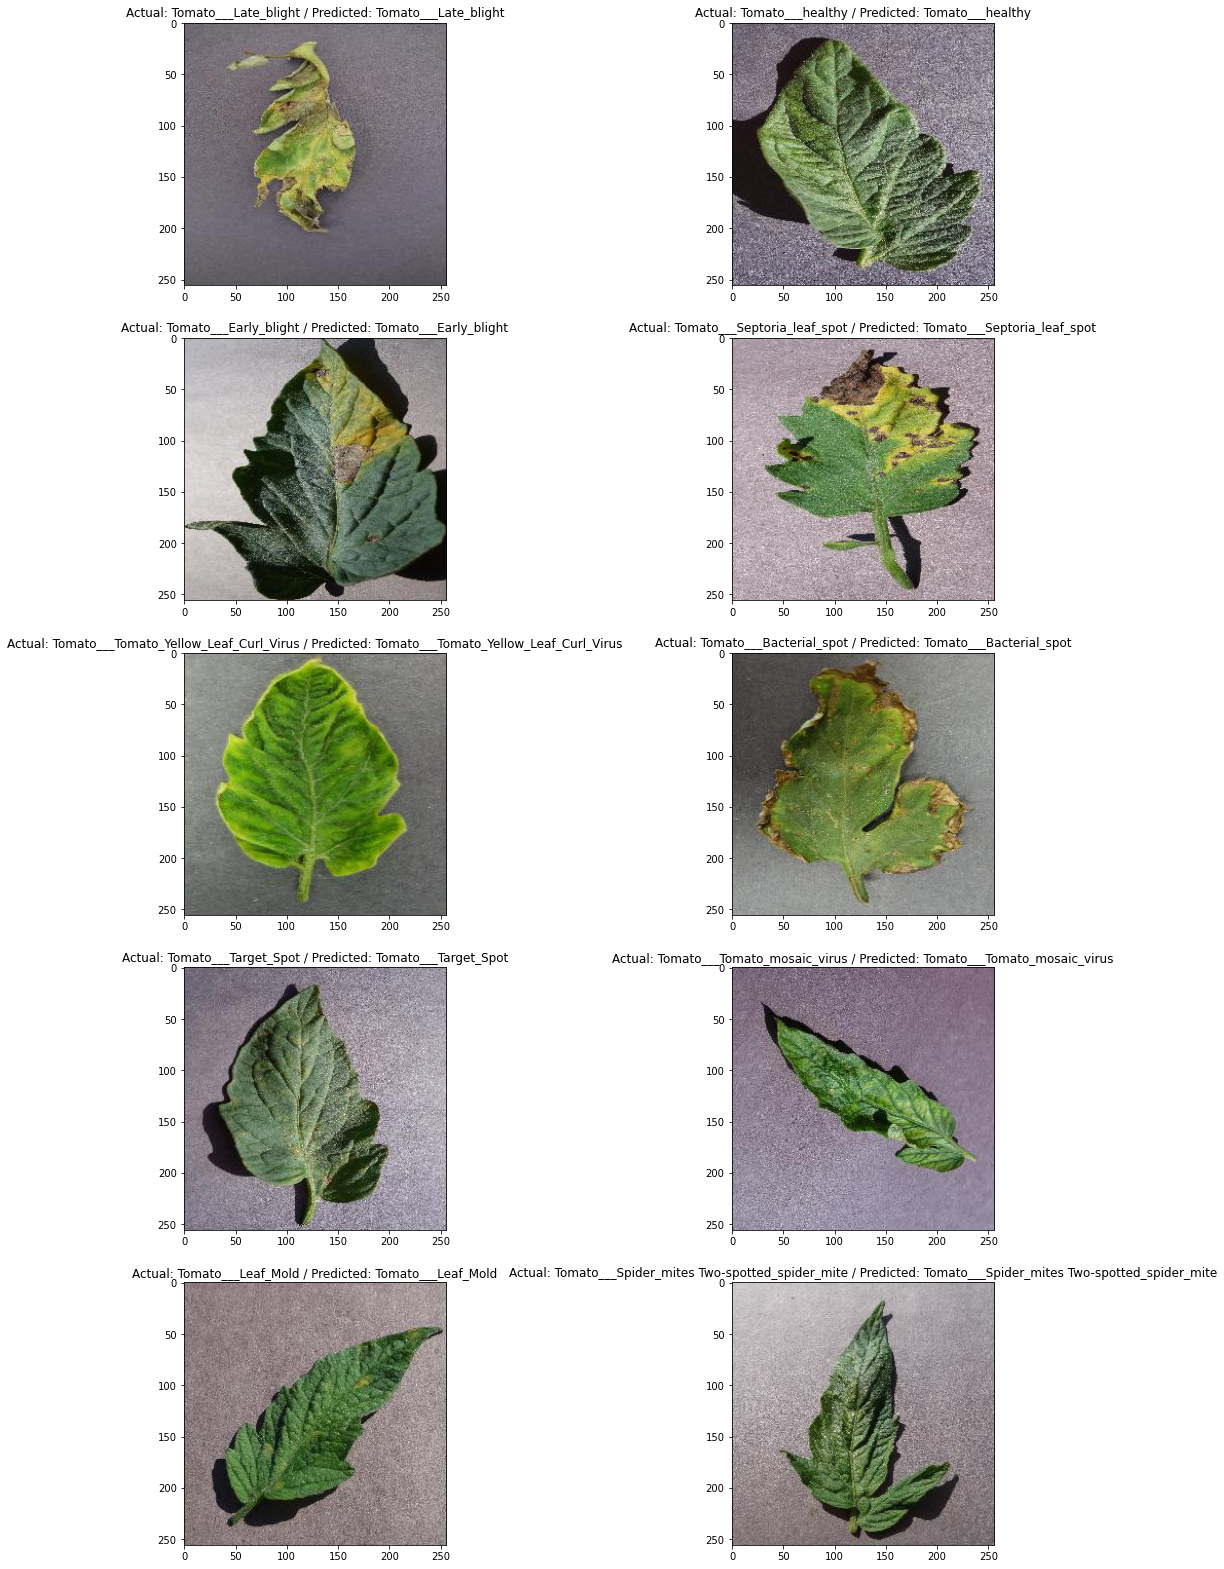

In [ ]:
# Prediction and visualizations

classes = os.listdir('./val')

plt.figure(figsize=(18,28))

for i in enumerate(classes):
    pic = os.listdir('./val/'+i[1])
    pic = pic[np.random.randint(len(pic)-1)]
    image = Image.open('./val/'+i[1]+'/'+pic)
    image = np.asarray(image)
    
    pred = np.argmax(model.predict(image.reshape(-1,256,256,3)/255))
    for j in list(enumerate(list(test.class_indices.keys()))):
        if pred == j[0]:
            prediction =  j[1]
    
    plt.subplot(5,2,i[0]+1)
    plt.title('Actual: {0} / Predicted: {1}'.format(i[1], prediction))
    plt.imshow(image)
plt.show()